In [1]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import seaborn as sns

import argparse
import os


In [2]:
# enable using seabord in jupyter notebook
%matplotlib inline


In [3]:
from utils import read_latest_results
import os

In [4]:
dataset = "amu-cai/pl-asr-bigos-v2-secret"
split = "test"

# print current dir
print(os.getcwd())

df_per_sample, df_per_dataset = read_latest_results(dataset, split)

/home/michal/Development/hugging-face/amu-cai/pl-asr-leaderboard
./data/amu-cai/pl-asr-bigos-v2-secret/test/eval_results-per_sample-latest.tsv
./data/amu-cai/pl-asr-bigos-v2-secret/test/eval_results-per_dataset-latest.tsv


In [5]:
df_per_sample.sample(3)

dataset             subset split ref_type  \
33265  amu-cai/pl-asr-bigos-v2-secret   google-fleurs-22  test     orig   
10816  amu-cai/pl-asr-bigos-v2-secret        fair-mls-20  test     orig   
23473  amu-cai/pl-asr-bigos-v2-secret  pwr-azon_spont-20  test     orig   

      eval_norm                         system  \
33265       all                google_v2_short   
10816       all  wav2vec2_large-xlsr-53-polish   
23473       all                   azure_latest   

                                          id  \
33265   google-fleurs-22-test-0003-00022.wav   
10816        fair-mls-20-test-0004-00027.wav   
23473  pwr-azon_spont-20-test-0003-00003.wav   

                                                     ref  \
33265  jedynym z siedmiu cudów świata zachowanym do d...   
10816  wygląda ona tak jak indyanin któryby zamiast o...   
23473  właśnie moja yyy dzisiejsza prezentacja której...   

                                                     hyp  audio_duration  \
33265  jedynym z siedmiu cudów świata zachowanym do d...            6.66   
10816  wygląda ona tak jakindyanin który zamiast okry...           16.74   
23473  właśnie moja dzisiejsza prezentacja której tem...           10.70   

         WIL    MER    WER   CER  
33265   0.00   0.00   0.00  0.00  
10816  42.31  26.83  28.21  5.56  
23473  41.52  27.78  29.41  8.33

In [46]:
# extract the fifth field from the audio file name stored in "id" column from the df_per_sample dataframe
spk_ids = df_per_sample['audio_filename'] = df_per_sample['id'].apply(lambda x: x.split('-')[1:5])
spk_ids = spk_ids.apply(lambda x: '-'.join(x))
df_per_sample['spk_id'] = spk_ids
df_per_sample.sample(3)
# print the number of unique speakers
print(f"Number of unique speakers: {df_per_sample['spk_id'].nunique()}")

Number of unique speakers: 88


In [51]:
# filter the df_per_sample dataframe to leave only unique audio recordings
df_per_sample_unique_audio = df_per_sample.drop_duplicates(subset='id')
# calculate the total size of the dataset in hours based on the list of unique audio recordings
total_duration_hours = df_per_sample_unique_audio['audio_duration'].sum() / 3600
print(f"Total duration of the dataset: {total_duration_hours:.2f} hours")



Total duration of the dataset: 4.85 hours


In [6]:
df_per_dataset.sample(3)

dataset                      subset split  \
79   amu-cai/pl-asr-bigos-v2-secret  mozilla-common_voice_15-23  test   
219  amu-cai/pl-asr-bigos-v2-secret           polyai-minds14-21  test   
169  amu-cai/pl-asr-bigos-v2-secret          pwr-shortwords-unk  test   

     samples ref_type eval_norm                    system    SER    WIL  \
79       200     orig       all            google_default  54.00  24.99   
219       53     orig       all      whisper_local_medium  79.25  37.36   
169       92     orig       all  wav2vec2_xls-r-1b-polish  35.87  12.93   

       MER    WER    CER  
79   15.49  15.73   6.08  
219  29.71  36.61  28.66  
169   7.38   7.43   1.11

In [7]:
cols_to_select = ["system", "subset", "SER", "WIL", "MER", "WER", "CER"]
# select only the columns we want to plot
df_per_dataset_selected_cols = df_per_dataset[cols_to_select]


In [29]:
evaluated_systems_list = df_per_sample["system"].unique()
evaluated_systems_list


array(['google_v2_long', 'google_v2_short', 'whisper_cloud_whisper-1',
       'google_default', 'google_command_and_search',
       'google_latest_long', 'google_latest_short', 'whisper_local_tiny',
       'whisper_local_base', 'whisper_local_small',
       'whisper_local_medium', 'whisper_local_large',
       'whisper_local_large-v1', 'whisper_local_large-v2', 'azure_latest',
       'nemo_stt_pl_fastconformer_hybrid_large_pc',
       'wav2vec2_large-xlsr-53-polish', 'wav2vec2_xls-r-1b-polish',
       'mms_1b-all'], dtype=object)

In [35]:
from utils import download_tsv_from_google_sheet
def retrieve_asr_systems_meta_from_the_catalog(asr_systems_list):
    # read the catalog
    print("Reading ASR systems catalog")
    asr_systems_cat_url = "https://docs.google.com/spreadsheets/d/1fVsE98Ulmt-EIEe4wx8sUdo7RLigDdAVjQxNpAJIrH8/edit#gid=681521237"
    catalog = download_tsv_from_google_sheet(asr_systems_cat_url)
    print("ASR systems catalog read")
    # filter only the systems we are interested in
    catalog = catalog[catalog["Codename"].isin(asr_systems_list)]

    return catalog

In [38]:
df_evaluated_systems_info = retrieve_asr_systems_meta_from_the_catalog(evaluated_systems_list)
df_evaluated_systems_info

Reading ASR systems catalog
ASR systems catalog read


Codename         System  \
0                     whisper_cloud_whisper-1  whisper_cloud   
1                                azure_latest          azure   
2                              google_v2_long      google_v2   
3                             google_v2_short      google_v2   
4                              google_default         google   
5                          google_latest_long         google   
6                         google_latest_short         google   
7                   google_command_and_search         google   
8                          whisper_local_tiny  whisper_local   
9                          whisper_local_base  whisper_local   
10                        whisper_local_small  whisper_local   
11                       whisper_local_medium  whisper_local   
12                        whisper_local_large  whisper_local   
13                     whisper_local_large-v2  whisper_local   
14                     whisper_local_large-v1  whisper_local   
15  nemo_stt_pl_fastconformer_hybrid_large_pc           nemo   
18                                 mms_1b-all            mms   

                                   Model  Link        Type Last update (YYMM)  
0                              whisper-1  todo  commercial               2403  
1                                 latest  todo  commercial               todo  
2                                   long  todo  commercial               todo  
3                                  short  todo  commercial               todo  
4                                default  todo  commercial               todo  
5                            latest_long  todo  commercial               todo  
6                           latest_short  todo  commercial               todo  
7                     command_and_search  todo  commercial               todo  
8                                   tiny  todo        free               todo  
9                                   base  todo        free               todo  
10                                 small  todo        free               todo  
11                                medium  todo        free               todo  
12                                 large  todo        free               2311  
13                              large-v2  todo        free               2209  
14                              large-v1  todo        free               2209  
15  stt_pl_fastconformer_hybrid_large_pc  todo        free               todo  
18                                1b-all  todo        free               todo

In [10]:
def get_asr_systems_metadata(asr_systems_list):
    asr_systems_metadata = {}
    for asr_system in asr_systems_list:
        asr_systems_metadata[asr_system] = {
            "color": sns.color_palette("husl", len(asr_systems_list))[list(asr_systems_list).index(asr_system)]
        }
    return asr_systems_metadata

In [11]:
asr_systems_metadata = get_asr_systems_metadata(evaluated_systems_list) 

In [12]:
import pandas as pd
from utils import basic_stats_per_dimension
basic_stats_per_dimension(df_per_dataset, "WER", "system")

avg_WER  med_WER  std_WER  min_WER  \
system                                                                          
whisper_local_large                           8.38     5.53     7.50     3.79   
whisper_local_large-v2                        9.58     6.61     8.68     5.03   
whisper_cloud_whisper-1                      10.05     5.97     8.53     4.17   
whisper_local_large-v1                       10.50     7.84     8.75     4.11   
google_latest_long                           11.12    10.26     7.74     0.00   
google_v2_long                               11.24    10.38     7.78     0.28   
whisper_local_medium                         11.52     9.03     8.62     5.94   
google_latest_short                          12.46    11.09     7.02     0.00   
wav2vec2_xls-r-1b-polish                     13.74    10.38     8.12     7.43   
google_command_and_search                    14.52    15.19     6.69     0.28   
nemo_stt_pl_fastconformer_hybrid_large_pc    15.03    12.75    10.65     2.10   
google_default                               15.53    16.51     7.29     0.28   
mms_1b-all                                   16.90    11.93    11.29     7.15   
google_v2_short                              17.80    14.98    13.71     0.00   
azure_latest                                 18.85    15.38    13.20     1.14   
whisper_local_small                          20.52    15.92    16.26     8.11   
wav2vec2_large-xlsr-53-polish                25.53    20.70    16.77     6.81   
whisper_local_base                           35.60    31.79    17.86    21.49   
whisper_local_tiny                           54.29    44.40    28.91    33.71   

                                           max_WER  
system                                              
whisper_local_large                          29.17  
whisper_local_large-v2                       35.32  
whisper_cloud_whisper-1                      31.85  
whisper_local_large-v1                       36.01  
google_latest_long                           26.28  
google_v2_long                               27.37  
whisper_local_medium                         36.61  
google_latest_short                          28.27  
wav2vec2_xls-r-1b-polish                     32.93  
google_command_and_search                    22.97  
nemo_stt_pl_fastconformer_hybrid_large_pc    42.56  
google_default                               25.22  
mms_1b-all                                   42.46  
google_v2_short                              52.73  
azure_latest                                 39.87  
whisper_local_small                          68.65  
wav2vec2_large-xlsr-53-polish                69.35  
whisper_local_base                           85.81  
whisper_local_tiny                          139.29

In [13]:
from utils import ser_from_per_sample_results
df_ser = ser_from_per_sample_results(df_per_sample, "system")
df_ser


system
whisper_local_large                          42.15
whisper_cloud_whisper-1                      44.86
whisper_local_large-v2                       45.18
whisper_local_large-v1                       50.23
google_latest_long                           51.98
google_v2_long                               52.36
whisper_local_medium                         53.36
nemo_stt_pl_fastconformer_hybrid_large_pc    59.41
google_latest_short                          59.61
azure_latest                                 59.81
wav2vec2_xls-r-1b-polish                     60.63
google_v2_short                              62.14
mms_1b-all                                   64.93
google_command_and_search                    65.36
google_default                               66.21
whisper_local_small                          67.74
wav2vec2_large-xlsr-53-polish                73.49
whisper_local_base                           85.25
whisper_local_tiny                           92.02
Name: SER, dtype: float6

In [14]:
df_ser = ser_from_per_sample_results(df_per_sample, "subset")
df_ser

subset
pwr-viu-unk                   16.00
pwr-maleset-unk               30.26
pwr-shortwords-unk            41.93
mozilla-common_voice_15-23    45.51
pjatk-clarin_studio-15        65.84
mailabs-corpus_librivox-19    69.58
pwr-azon_read-20              69.87
google-fleurs-22              76.47
polyai-minds14-21             80.06
pjatk-clarin_mobile-15        84.19
fair-mls-20                   85.08
pwr-azon_spont-20             98.90
Name: SER, dtype: float64

In [15]:
basic_stats_per_dimension(df_per_dataset, "SER", "system")

avg_SER  med_SER  std_SER  min_SER  \
system                                                                          
whisper_local_large                          47.81    48.75    25.74     10.5   
whisper_cloud_whisper-1                      50.61    50.75    25.48     16.5   
whisper_local_large-v2                       50.70    52.75    26.18      8.5   
whisper_local_large-v1                       54.86    60.00    26.25     11.5   
google_latest_long                           55.88    63.00    29.55      0.0   
google_v2_long                               55.99    63.25    29.17      0.5   
whisper_local_medium                         57.65    62.75    26.56     11.5   
google_latest_short                          61.25    64.74    31.67      0.0   
azure_latest                                 62.49    75.50    32.47      2.0   
google_v2_short                              63.72    68.53    31.35      0.0   
nemo_stt_pl_fastconformer_hybrid_large_pc    63.72    75.25    30.80     12.0   
wav2vec2_xls-r-1b-polish                     64.27    68.00    27.53     16.0   
google_command_and_search                    66.57    75.25    31.74      0.5   
google_default                               67.36    76.75    32.11      0.5   
mms_1b-all                                   68.93    70.50    20.17     42.0   
whisper_local_small                          70.11    77.75    23.88     33.5   
wav2vec2_large-xlsr-53-polish                77.14    82.75    24.70     17.5   
whisper_local_base                           86.44    93.86    15.81     53.0   
whisper_local_tiny                           92.61    97.12    11.39     61.0   

                                           max_SER  
system                                              
whisper_local_large                          95.83  
whisper_cloud_whisper-1                     100.00  
whisper_local_large-v2                       97.92  
whisper_local_large-v1                       97.92  
google_latest_long                           97.92  
google_v2_long                               95.83  
whisper_local_medium                        100.00  
google_latest_short                          97.87  
azure_latest                                 97.92  
google_v2_short                              97.83  
nemo_stt_pl_fastconformer_hybrid_large_pc   100.00  
wav2vec2_xls-r-1b-polish                    100.00  
google_command_and_search                   100.00  
google_default                              100.00  
mms_1b-all                                  100.00  
whisper_local_small                         100.00  
wav2vec2_large-xlsr-53-polish               100.00  
whisper_local_base                          100.00  
whisper_local_tiny                          100.00

In [16]:
basic_stats_per_dimension(df_per_sample, "WER", "system")

avg_WER  med_WER  std_WER  min_WER  \
system                                                                          
whisper_local_large                           6.92     0.00    21.64      0.0   
whisper_local_large-v2                        8.21     0.00    24.90      0.0   
whisper_cloud_whisper-1                       8.97     0.00    25.66      0.0   
google_latest_long                            9.14     3.45    14.34      0.0   
google_v2_long                                9.19     3.57    14.39      0.0   
whisper_local_large-v1                        9.23     2.38    23.39      0.0   
whisper_local_medium                         10.09     3.70    23.53      0.0   
wav2vec2_xls-r-1b-polish                     12.07     7.60    17.57      0.0   
google_latest_short                          12.20     6.90    16.59      0.0   
nemo_stt_pl_fastconformer_hybrid_large_pc    14.03     6.67    29.78      0.0   
google_command_and_search                    14.62    10.34    17.39      0.0   
google_default                               15.32    12.00    17.45      0.0   
mms_1b-all                                   15.70     9.09    28.94      0.0   
azure_latest                                 16.44     8.33    22.00      0.0   
google_v2_short                              16.88     8.33    22.06      0.0   
whisper_local_small                          19.16    11.11    40.95      0.0   
wav2vec2_large-xlsr-53-polish                22.17    16.67    27.69      0.0   
whisper_local_base                           35.17    27.27    41.60      0.0   
whisper_local_tiny                           54.11    43.90    84.01      0.0   

                                           max_WER  
system                                              
whisper_local_large                         616.67  
whisper_local_large-v2                      600.00  
whisper_cloud_whisper-1                     616.67  
google_latest_long                          100.00  
google_v2_long                              100.00  
whisper_local_large-v1                      616.67  
whisper_local_medium                        650.00  
wav2vec2_xls-r-1b-polish                    200.00  
google_latest_short                         100.00  
nemo_stt_pl_fastconformer_hybrid_large_pc   616.67  
google_command_and_search                   166.67  
google_default                              166.67  
mms_1b-all                                  666.67  
azure_latest                                120.00  
google_v2_short                             100.00  
whisper_local_small                        1100.00  
wav2vec2_large-xlsr-53-polish               633.33  
whisper_local_base                          616.67  
whisper_local_tiny                         1900.00

In [17]:
basic_stats_per_dimension(df_per_sample, "MER", "system")

avg_MER  med_MER  std_MER  min_MER  \
system                                                                          
whisper_local_large                           6.13     0.00    12.09      0.0   
whisper_local_large-v2                        7.22     0.00    13.86      0.0   
whisper_cloud_whisper-1                       8.04     0.00    17.29      0.0   
whisper_local_large-v1                        8.30     2.38    14.55      0.0   
google_latest_long                            8.92     3.33    14.02      0.0   
google_v2_long                                8.95     3.57    14.00      0.0   
whisper_local_medium                          9.06     3.70    14.72      0.0   
wav2vec2_xls-r-1b-polish                     11.52     7.41    16.00      0.0   
google_latest_short                          11.84     6.90    16.07      0.0   
nemo_stt_pl_fastconformer_hybrid_large_pc    12.11     6.67    16.92      0.0   
google_command_and_search                    13.87    10.34    15.91      0.0   
mms_1b-all                                   14.56     8.89    20.84      0.0   
google_default                               14.59    11.76    16.05      0.0   
azure_latest                                 15.48     8.16    20.68      0.0   
whisper_local_small                          16.47    11.11    21.10      0.0   
google_v2_short                              16.60     8.33    21.80      0.0   
wav2vec2_large-xlsr-53-polish                20.66    16.67    20.85      0.0   
whisper_local_base                           30.70    25.71    25.25      0.0   
whisper_local_tiny                           43.49    40.91    25.78      0.0   

                                           max_MER  
system                                              
whisper_local_large                          100.0  
whisper_local_large-v2                       100.0  
whisper_cloud_whisper-1                      100.0  
whisper_local_large-v1                       100.0  
google_latest_long                           100.0  
google_v2_long                               100.0  
whisper_local_medium                         100.0  
wav2vec2_xls-r-1b-polish                     100.0  
google_latest_short                          100.0  
nemo_stt_pl_fastconformer_hybrid_large_pc    100.0  
google_command_and_search                    100.0  
mms_1b-all                                   100.0  
google_default                               100.0  
azure_latest                                 100.0  
whisper_local_small                          100.0  
google_v2_short                              100.0  
wav2vec2_large-xlsr-53-polish                100.0  
whisper_local_base                           100.0  
whisper_local_tiny                           100.0

In [18]:
basic_stats_per_dimension(df_per_sample, "CER", "system")

avg_CER  med_CER  std_CER  min_CER  \
system                                                                          
whisper_local_large                           3.39     0.00    20.48      0.0   
wav2vec2_xls-r-1b-polish                      3.46     1.14     7.72      0.0   
whisper_local_large-v2                        3.91     0.00    23.49      0.0   
whisper_local_large-v1                        4.12     0.45    21.50      0.0   
whisper_cloud_whisper-1                       4.15     0.00    21.66      0.0   
whisper_local_medium                          4.16     0.62    21.06      0.0   
google_v2_long                                4.47     0.66    11.74      0.0   
google_latest_long                            4.66     0.67    12.03      0.0   
mms_1b-all                                    4.69     1.47    20.36      0.0   
nemo_stt_pl_fastconformer_hybrid_large_pc     5.48     1.36    21.92      0.0   
google_command_and_search                     5.80     2.70    10.84      0.0   
google_default                                6.43     3.26    10.97      0.0   
google_latest_short                           6.64     1.82    13.00      0.0   
wav2vec2_large-xlsr-53-polish                 6.70     3.04    20.78      0.0   
whisper_local_small                           7.22     2.17    34.61      0.0   
azure_latest                                  8.97     1.79    18.66      0.0   
google_v2_short                              11.25     2.48    20.09      0.0   
whisper_local_base                           11.94     6.14    29.11      0.0   
whisper_local_tiny                           20.23    11.20    67.47      0.0   

                                           max_CER  
system                                              
whisper_local_large                         762.50  
wav2vec2_xls-r-1b-polish                     97.83  
whisper_local_large-v2                      743.75  
whisper_local_large-v1                      796.88  
whisper_cloud_whisper-1                     762.50  
whisper_local_medium                        803.12  
google_v2_long                               94.68  
google_latest_long                           94.68  
mms_1b-all                                  793.75  
nemo_stt_pl_fastconformer_hybrid_large_pc   771.88  
google_command_and_search                    96.81  
google_default                               96.81  
google_latest_short                          96.39  
wav2vec2_large-xlsr-53-polish               781.25  
whisper_local_small                        1118.28  
azure_latest                                 98.20  
google_v2_short                              98.94  
whisper_local_base                          771.88  
whisper_local_tiny                         2042.86

In [19]:
#print only ref hyp and WER for the worst samples
df_per_sample.sort_values(by='WER', ascending=False).head(10)[['subset', 'id', 'system', 'ref','hyp','WER']]

subset  \
30825                 pwr-viu-unk   
37224           polyai-minds14-21   
37207           polyai-minds14-21   
37204           polyai-minds14-21   
37310           polyai-minds14-21   
30832                 pwr-viu-unk   
37776           polyai-minds14-21   
37217           polyai-minds14-21   
37376           polyai-minds14-21   
16760  mozilla-common_voice_15-23   

                                                   id                system  \
30825                 pwr-viu-unk-test-0003-00363.wav    whisper_local_tiny   
37224           polyai-minds14-21-test-0003-00050.wav    whisper_local_tiny   
37207           polyai-minds14-21-test-0003-00033.wav    whisper_local_tiny   
37204           polyai-minds14-21-test-0003-00030.wav    whisper_local_tiny   
37310           polyai-minds14-21-test-0003-00030.wav   whisper_local_small   
30832                 pwr-viu-unk-test-0003-00377.wav    whisper_local_tiny   
37776           polyai-minds14-21-test-0003-00043.wav            mms_1b-all   
37217           polyai-minds14-21-test-0003-00043.wav    whisper_local_tiny   
37376           polyai-minds14-21-test-0003-00043.wav  whisper_local_medium   
16760  mozilla-common_voice_15-23-test-1618-00006.wav    whisper_local_tiny   

                                                     ref  \
30825                                            wyczyść   
37224  dzień dobry chciałbym wpłacić gotówkę na konto...   
37207  dzień dobry mam problem ze swoją kartą próbuję...   
37204  dzień dobry chciałabym się dowiedzieć i jakie ...   
37310  dzień dobry chciałabym się dowiedzieć i jakie ...   
30832                                             cofnij   
37776                   dzień dobry pani ja mam potrzebę   
37217                   dzień dobry pani ja mam potrzebę   
37376                   dzień dobry pani ja mam potrzebę   
16760                       sumienie go ujęło podstępnie   

                                                     hyp      WER  
30825  wit exhausting się z nas samaspeaksistna odwie...  1900.00  
37224  dzień dobry chciałbym płacil go tu w kanaekąto...  1541.67  
37207  dzień dobry mam problem ze słyukartą próbuj uż...  1342.86  
37204  dzień dobry chciałabym się do wiedzieć i jakie...  1226.67  
37310  dzień dobry chciałabym się dowiedzieć jakie je...  1100.00  
30832  to s然creamuắm on jest nawet determinowi usda z...  1100.00  
37776  dzieńdory w panie ja mam potrzebę wpłacić dużą...   666.67  
37217  dzień dobry wpają ja mam potrzeby w płacić duż...   666.67  
37376  dzień dobry panie i panie ja mam potrzebę wpła...   650.00  
16760  sob mean guys adesso tam ogieło tego pod auste...   650.00

In [20]:
df_per_sample.sort_values(by='WER', ascending=False).head(10)[['subset', 'id', 'system', 'ref','hyp','MER']]

subset  \
30825                 pwr-viu-unk   
37224           polyai-minds14-21   
37207           polyai-minds14-21   
37204           polyai-minds14-21   
37310           polyai-minds14-21   
30832                 pwr-viu-unk   
37776           polyai-minds14-21   
37217           polyai-minds14-21   
37376           polyai-minds14-21   
16760  mozilla-common_voice_15-23   

                                                   id                system  \
30825                 pwr-viu-unk-test-0003-00363.wav    whisper_local_tiny   
37224           polyai-minds14-21-test-0003-00050.wav    whisper_local_tiny   
37207           polyai-minds14-21-test-0003-00033.wav    whisper_local_tiny   
37204           polyai-minds14-21-test-0003-00030.wav    whisper_local_tiny   
37310           polyai-minds14-21-test-0003-00030.wav   whisper_local_small   
30832                 pwr-viu-unk-test-0003-00377.wav    whisper_local_tiny   
37776           polyai-minds14-21-test-0003-00043.wav            mms_1b-all   
37217           polyai-minds14-21-test-0003-00043.wav    whisper_local_tiny   
37376           polyai-minds14-21-test-0003-00043.wav  whisper_local_medium   
16760  mozilla-common_voice_15-23-test-1618-00006.wav    whisper_local_tiny   

                                                     ref  \
30825                                            wyczyść   
37224  dzień dobry chciałbym wpłacić gotówkę na konto...   
37207  dzień dobry mam problem ze swoją kartą próbuję...   
37204  dzień dobry chciałabym się dowiedzieć i jakie ...   
37310  dzień dobry chciałabym się dowiedzieć i jakie ...   
30832                                             cofnij   
37776                   dzień dobry pani ja mam potrzebę   
37217                   dzień dobry pani ja mam potrzebę   
37376                   dzień dobry pani ja mam potrzebę   
16760                       sumienie go ujęło podstępnie   

                                                     hyp     MER  
30825  wit exhausting się z nas samaspeaksistna odwie...  100.00  
37224  dzień dobry chciałbym płacil go tu w kanaekąto...   96.35  
37207  dzień dobry mam problem ze słyukartą próbuj uż...   95.43  
37204  dzień dobry chciałabym się do wiedzieć i jakie...   94.85  
37310  dzień dobry chciałabym się dowiedzieć jakie je...   92.18  
30832  to s然creamuắm on jest nawet determinowi usda z...  100.00  
37776  dzieńdory w panie ja mam potrzebę wpłacić dużą...   93.02  
37217  dzień dobry wpają ja mam potrzeby w płacić duż...   90.91  
37376  dzień dobry panie i panie ja mam potrzebę wpła...   88.64  
16760  sob mean guys adesso tam ogieło tego pod auste...  100.00

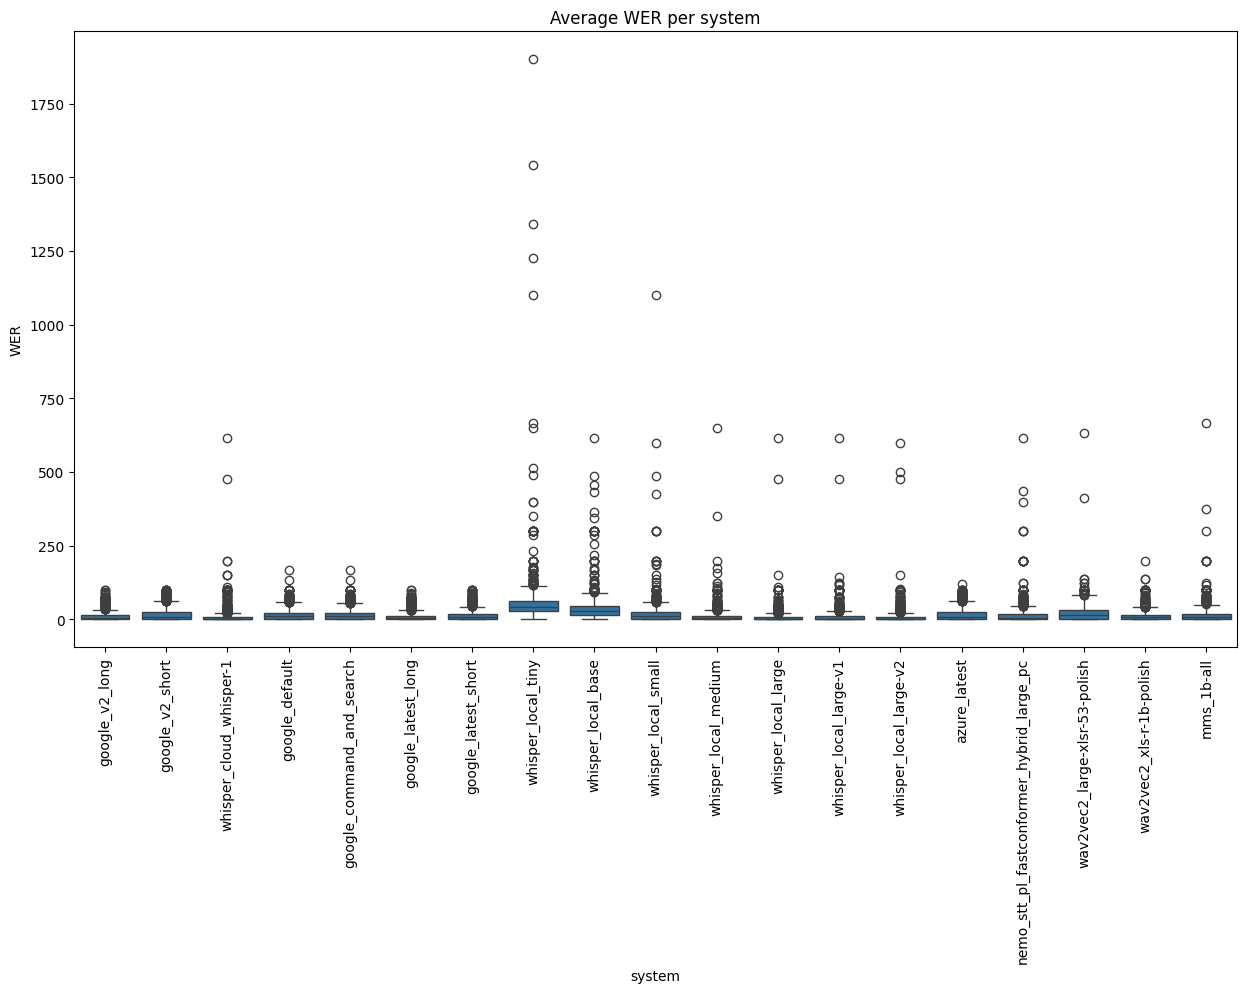

In [21]:
# plot average WER per system
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_per_sample, x='system', y='WER')
plt.xticks(rotation=90)
plt.title('Average WER per system')
plt.show()




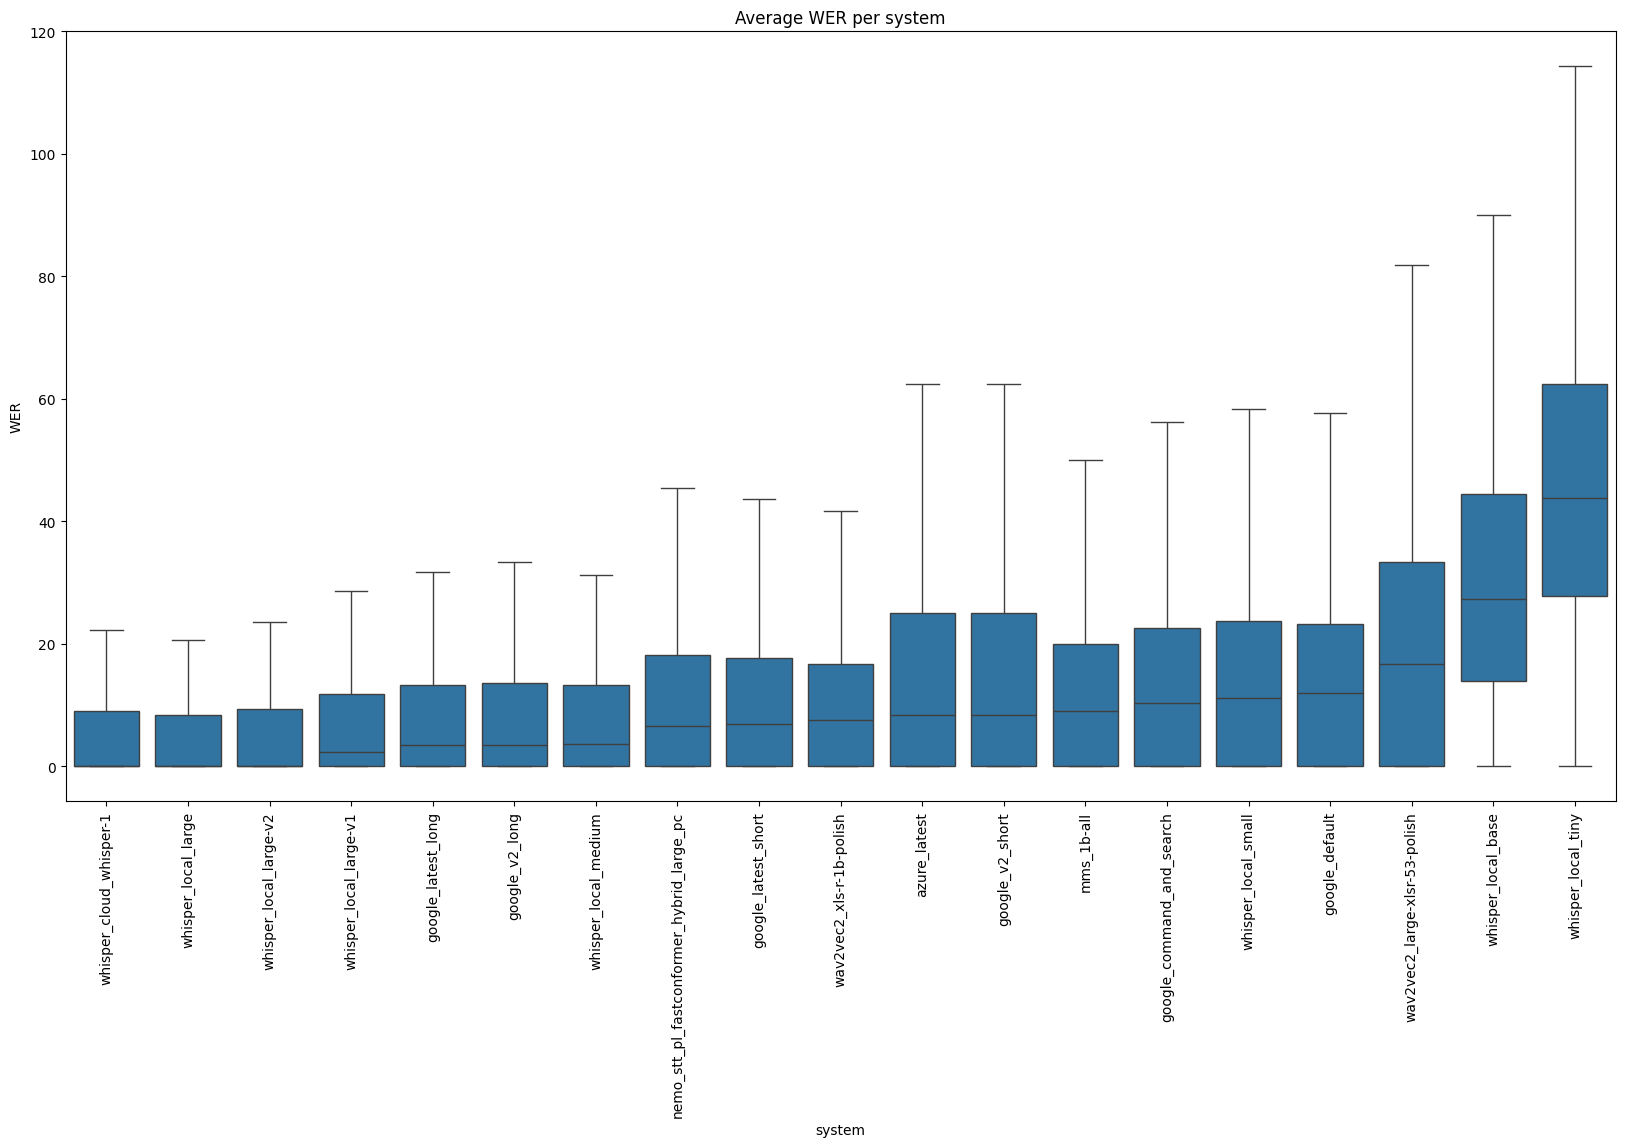

In [22]:
from utils import box_plot_per_dimension

plot = box_plot_per_dimension(df_per_sample, "WER", "system", "Average WER per system", "system", "WER")
plot.show()


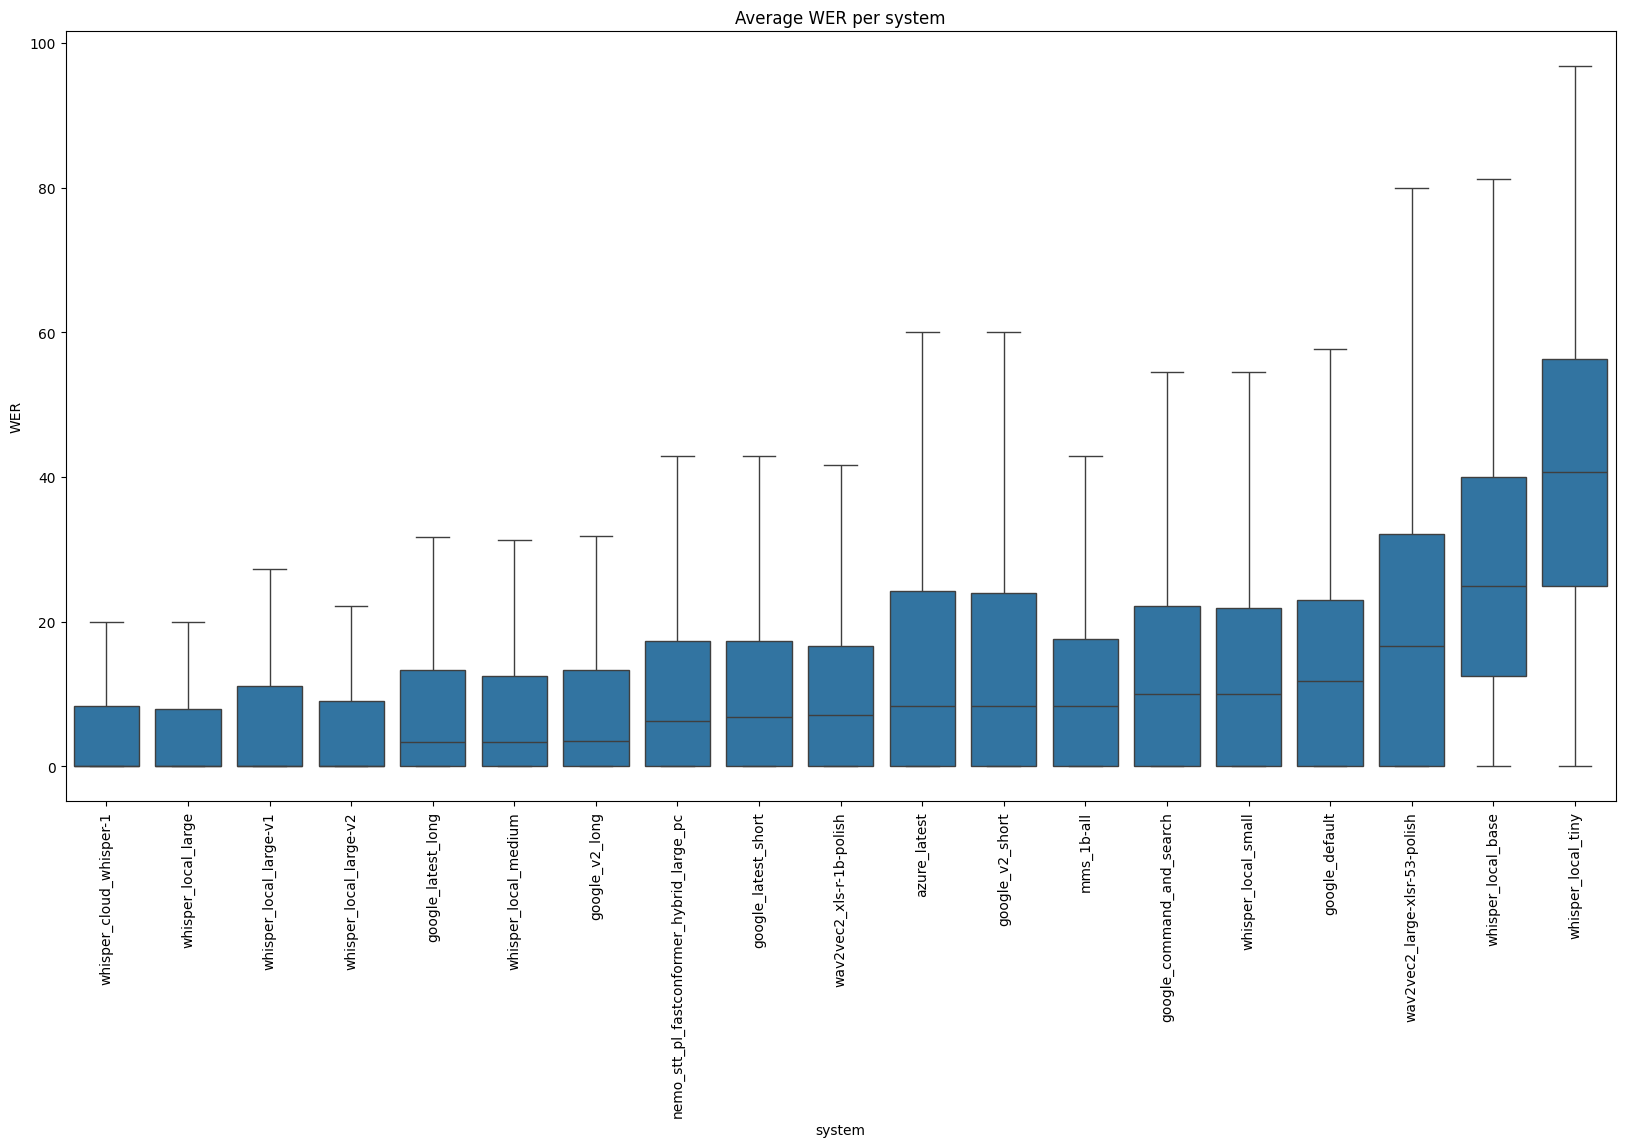

In [23]:
from utils import filter_top_outliers, filter_bottom_outliers
df_per_sample_filtered = filter_top_outliers(df_per_sample, "WER", 100)

plot = box_plot_per_dimension(df_per_sample_filtered, "WER", "system", "Average WER per system", "system", "WER")
plot.show()


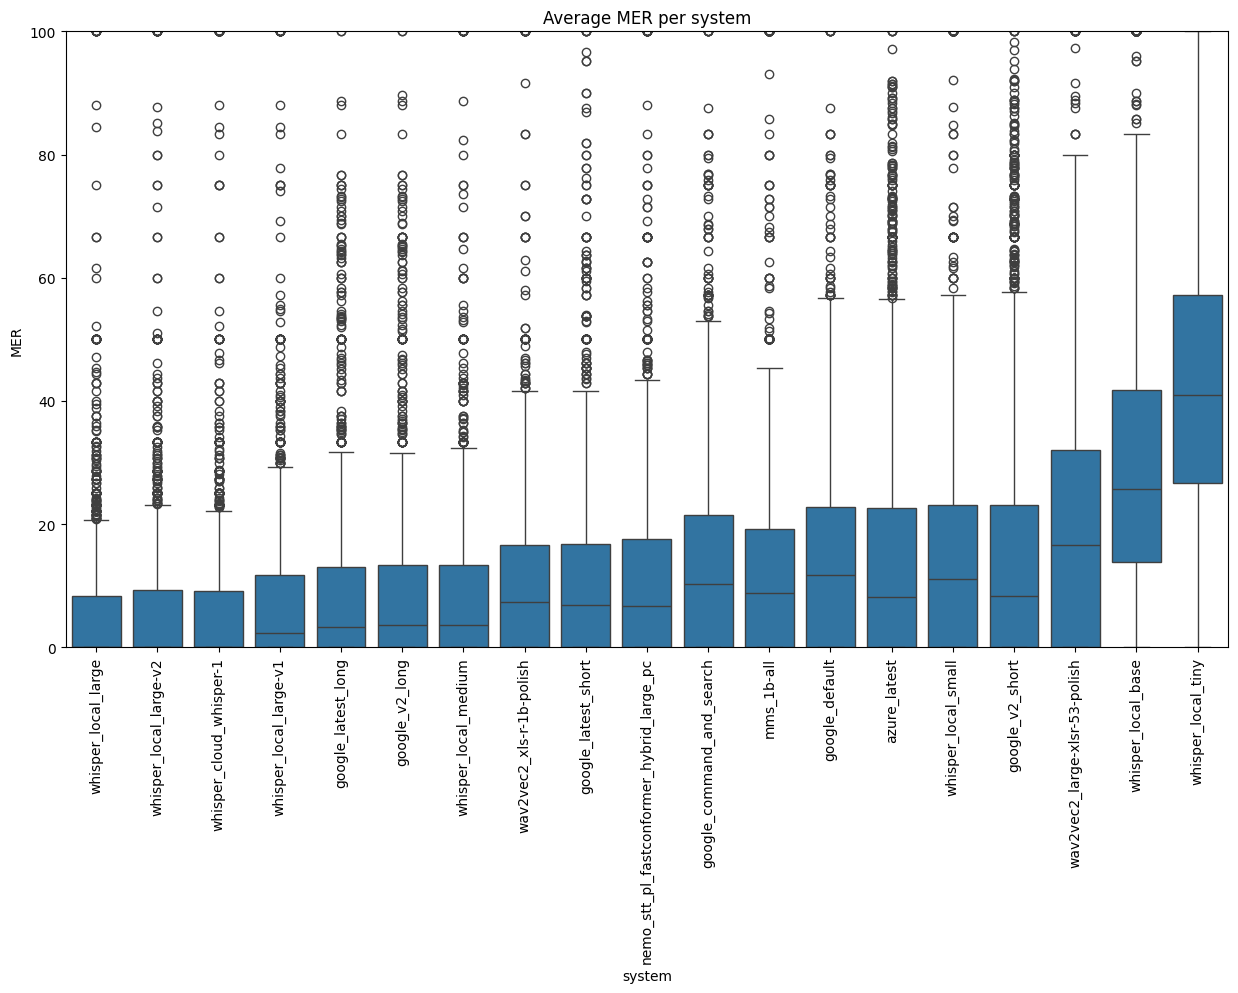

In [24]:
# plot average WER per system sorted by WER
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_per_sample, x='system', y='MER', order=df_per_sample.groupby('system')['MER'].mean().sort_values().index)
# limit y axis to 0-1
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.title('Average MER per system')
plt.show()


In [25]:
#generate average WER per specific sample (based on 'id' column) for all systems
df_per_sample_all_systems = df_per_sample.groupby(['id', 'system', 'ref', 'hyp', 'ref_words', 'hyp_words', 'ref_wps', 'hyp_wps']).agg({'WER': 'mean'}).reset_index()
# sort by WER
df_per_sample_all_systems.sort_values(by='WER', ascending=False).head(10)


KeyError: 'ref_words'

In [ ]:
#filter out results where ref_wps < 0.8
df_per_sample_all_systems = df_per_sample_all_systems[df_per_sample_all_systems['ref_wps'] > 0.8]
df_per_sample_all_systems.sort_values(by='WER', ascending=False).head(20)


id  \
37444                 pwr-viu-unk-test-0003-00363.wav   
37577                 pwr-viu-unk-test-0003-00377.wav   
12748  mozilla-common_voice_15-23-test-1618-00006.wav   
23196           polyai-minds14-21-test-0003-00023.wav   
14929  mozilla-common_voice_15-23-test-2725-00005.wav   
14059  mozilla-common_voice_15-23-test-2295-00004.wav   
13369  mozilla-common_voice_15-23-test-1907-00001.wav   
37419                 pwr-viu-unk-test-0003-00361.wav   
35971                 pwr-viu-unk-test-0003-00209.wav   
34270                 pwr-viu-unk-test-0003-00029.wav   
35590                 pwr-viu-unk-test-0003-00169.wav   
34384                 pwr-viu-unk-test-0003-00041.wav   
35215                 pwr-viu-unk-test-0003-00129.wav   
35595                 pwr-viu-unk-test-0003-00169.wav   
35886                 pwr-viu-unk-test-0003-00199.wav   
35220                 pwr-viu-unk-test-0003-00129.wav   
36817                 pwr-viu-unk-test-0003-00297.wav   
35600                 pwr-viu-unk-test-0003-00169.wav   
37311                 pwr-viu-unk-test-0003-00349.wav   
34708                 pwr-viu-unk-test-0003-00075.wav   

                                          system  \
37444                         whisper_local_tiny   
37577                         whisper_local_tiny   
12748                         whisper_local_tiny   
23196                         whisper_local_tiny   
14929                        whisper_local_small   
14059                         whisper_local_tiny   
13369                         whisper_local_base   
37419                         whisper_local_base   
35971  nemo_stt_pl_fastconformer_hybrid_large_pc   
34270                        whisper_local_small   
35590                                 mms_1b-all   
34384                        whisper_local_small   
35215                         whisper_local_base   
35595                         whisper_local_base   
35886                         whisper_local_tiny   
35220                        whisper_local_small   
36817                         whisper_local_tiny   
35600                        whisper_local_small   
37311                         whisper_local_tiny   
34708                         whisper_local_tiny   

                                                     ref  \
37444                                            wyczyść   
37577                                             cofnij   
12748                       sumienie go ujęło podstępnie   
23196  dzień dobry chciałbym zmienić twój adres zamie...   
14929                                eee pod wodę trudno   
14059                           jedyny motyw dla malarza   
13369  w dziecinnym głosie brzmiał zawód i powątpiewanie   
37419                                             cofnij   
35971                                             cofnij   
34270                                             cofnij   
35590                                             cofnij   
34384                                            zakończ   
35215                                             cofnij   
35595                                             cofnij   
35886                                             cofnij   
35220                                             cofnij   
36817                                             cofnij   
35600                                             cofnij   
37311                                             cofnij   
34708                                             cofnij   

                                                     hyp  ref_words  \
37444  wit exhausting się z nas samaspeaksistna odwie...          1   
37577  to s然creamuắm on jest nawet determinowi usda z...          1   
12748  sob mean guys adesso tam ogieło tego pod auste...          4   
23196  cię na brę w ciągu wyzwój twój adres z samej s...         42   
14929  mnn amigo packages sp innen workplace polsko s...          4   
14059  i e beni mamy już innym muzeku i nie ten cut c...          4   
13

In [ ]:
# Weigthted average WER per system based on df_per_dataset
df_weighted_avg_wer_per_system_from_per_dataset = df_per_dataset.groupby("system").apply(lambda x: (x["WER"] * x["samples"]).sum() / x["samples"].sum()).sort_values().round(2)
df_weighted_avg_wer_per_system_from_per_dataset

In [ ]:
df_per_subset_avg_wer = df_per_sample.groupby(['subset', 'system']).agg({'WER': 'mean'}).reset_index()
df_per_subset_med_wer = df_per_sample.groupby(['subset', 'system']).agg({'WER': 'median'}).reset_index()
df_per_subset_std_wer = df_per_sample.groupby(['subset', 'system']).agg({'WER': 'std'}).reset_index()
# calculate min and max WER for each subset
df_per_subset_min_wer = df_per_sample.groupby(['subset', 'system']).agg({'WER': 'min'}).reset_index()
df_per_subset_max_wer = df_per_sample.groupby(['subset', 'system']).agg({'WER': 'max'}).reset_index()

# concatenate the two dataframes
df_per_subset_avg_wer['metric'] = 'avg'
df_per_subset_med_wer['metric'] = 'median'
df_per_subset_std_wer['metric'] = 'std'
df_per_subset_min_wer['metric'] = 'min'
df_per_subset_max_wer['metric'] = 'max'

# round values to 2 decimal places
df_per_subset_avg_wer['WER'] = df_per_subset_avg_wer['WER'].round(2)
df_per_subset_med_wer['WER'] = df_per_subset_med_wer['WER'].round(2)
df_per_subset_std_wer['WER'] = df_per_subset_std_wer['WER'].round(2)
df_per_subset_min_wer['WER'] = df_per_subset_min_wer['WER'].round(2)
df_per_subset_max_wer['WER'] = df_per_subset_max_wer['WER'].round(2)

df_per_subset = pd.concat([df_per_subset_avg_wer, df_per_subset_std_wer, df_per_subset_med_wer, df_per_subset_min_wer, df_per_subset_max_wer])
# pivot so that average and median values are in separate columns

df_per_subset = df_per_subset.pivot(index=['subset', 'system'], columns='metric', values='WER').reset_index()

df_per_subset.sample(10)


metric                      subset                  system    avg     max  \
185                pwr-maleset-unk  whisper_local_large-v1   5.92  100.00   
41      mailabs-corpus_librivox-19      google_latest_long  10.76   66.67   
15                     fair-mls-20  whisper_local_large-v2   4.98   24.00   
213                    pwr-viu-unk     google_latest_short   0.00    0.00   
197             pwr-shortwords-unk              mms_1b-all  13.68  100.00   
194             pwr-shortwords-unk     google_latest_short   7.79  100.00   
166              pwr-azon_spont-20  whisper_local_large-v1  17.43   38.98   
69      mozilla-common_voice_15-23      whisper_local_base  40.62  342.86   
159              pwr-azon_spont-20              mms_1b-all  24.09   54.55   
53      mailabs-corpus_librivox-19  whisper_local_large-v2   7.27   66.67   

metric  median   min    std  
185       0.00  0.00  14.24  
41        7.14  0.00  12.47  
15        4.08  0.00   5.05  
213       0.00  0.00   0.00  
197      10.00  0.00  19.00  
194       0.00  0.00  15.19  
166      15.96  0.00   7.63  
69       33.33  0.00  37.21  
159      24.06  7.14   9.49  
53        4.17  0.00  10.16

In [ ]:
df_per_dataset = df_per_sample.groupby('dataset').agg({'WER': 'mean'}).reset_index()
df_per_dataset.sample(1)

dataset        WER
0  amu-cai/pl-asr-bigos-v2-secret  16.300518

In [ ]:
df_per_system = df_per_sample.groupby(['system']).agg({'WER': 'mean'}).reset_index()
df_per_system.head(50)

system        WER
0                                azure_latest  16.441846
1                   google_command_and_search  14.622314
2                              google_default  15.321516
3                          google_latest_long   9.135650
4                         google_latest_short  12.197692
5                              google_v2_long   9.194960
6                             google_v2_short  16.875613
7                                  mms_1b-all  15.699990
8   nemo_stt_pl_fastconformer_hybrid_large_pc  14.027657
9               wav2vec2_large-xlsr-53-polish  22.171245
10                   wav2vec2_xls-r-1b-polish  12.069904
11                    whisper_cloud_whisper-1   8.965871
12                         whisper_local_base  35.171550
13                        whisper_local_large   6.920015
14                     whisper_local_large-v1   9.228981
15                     whisper_local_large-v2   8.212766
16                       whisper_local_medium  10.092580
17                        whisper_local_small  19.163126
18                         whisper_local_tiny  54.107301

In [ ]:
def boxplot_performance(data, dim, metric, save_path):
    """
    Plots a box plot showing the distribution of a specified metric per provided dimension e.g. dataset, system, split etc.

    Parameters:
    - data: pandas DataFrame containing the ASR evaluation results.
    - dimn: The dimension to use for the box plot (e.g., 'dataset', 'system').
    - metric: The metric to use for the box plot (e.g., 'SER', 'WER').
    - save_path: The path where the plot image will be saved.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=dim, y=metric, data=data)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Box Plot of {metric} Per {dim}')
    plt.xlabel(dim)
    plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def boxplot_wer_per_dataset(eval_results, save_path='./data/eval_plots'):
    # Load the data
    data = pd.read_csv(eval_results, sep='\t')
    today = pd.Timestamp.now().strftime('%Y%m%d')
    os.makedirs(os.path.join(save_path, today), exist_ok=True)

    # Plot and save the figures
    boxplot_performance(data, "dataset", "WER", os.path.join(save_path, "WER-across-systems.png"))

#def wer_per_audio_duration

def parse_arguments():
    parser = argparse.ArgumentParser(description='ASR Evaluation Analysis')
    parser.add_argument('--analysis_type', type=str, help="WER_PER_AUDIO_DURATION or WER_PER_SYSTEM or WER_PER_DATASET")
    parser.add_argument('--eval_results', type=str, help='Path to the TSV file')
    parser.add_argument('--dim', type=str, default='dataset', help='Dimension to plot (default: dataset)')
    parser.add_argument('--metric', type=str, default='WER', help='Metric to plot (default: WER)')
    parser.add_argument('--save_path', type=str, default='.', help='Path to save the plots')
    return parser.parse_args()

In [ ]:
def calculate_wer_summary(data, output_csv_path):
    # TODO - split system and model into separate columns?

    # Pivot the data to have one row per system/model with columns for each dataset's WER
    pivot_data = data.pivot_table(index='system', columns='dataset', values='WER', aggfunc='mean').reset_index()
    
    # change values in the dataset column, so that they are more human readable
    pivot_data.columns = pivot_data.columns.str.replace("test-", "")
    pivot_data.columns = pivot_data.columns.str.replace("valdation-", "")
    pivot_data.columns = pivot_data.columns.str.replace("train-", "")

    # Calculate average WER and weighted average WER with 2 decimal places precision

    data['weighted_wer'] = data['WER'] * data['samples']
    avg_wer = data.groupby('system')['WER'].mean().reset_index(name='avg. WER')
    wavg_wer = data.groupby('system')['weighted_wer'].sum() / data.groupby('system')['samples'].sum()
    wavg_wer = wavg_wer.reset_index(name='wavg. WER')
    # Round the WER values to 2 decimal places
    avg_wer['avg. WER'] = avg_wer['avg. WER'].round(2)
    wavg_wer['wavg. WER'] = wavg_wer['wavg. WER'].round(2)

    # Merge average and weighted average WER with pivot data
    summary_data = pd.merge(pivot_data, avg_wer, on='system')
    summary_data = pd.merge(summary_data, wavg_wer, on='system')
    
    # move columns with avg_wer and wavg_wer to the beginnging (after system and model columns)
    cols = summary_data.columns.tolist()
    cols = cols[:1] + cols[-2:] + cols[1:-2]
    summary_data = summary_data[cols]

    # Rename columns to match the provided CSV format, if necessary
    # This step would require specific column name mappings based on your example CSV
    
    # Save the summarized data to a CSV file
    summary_data.to_csv(output_csv_path, index=False)
    return summary_data
